# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

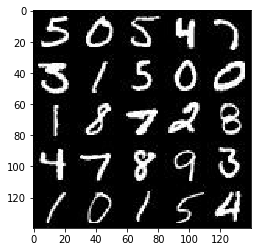

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

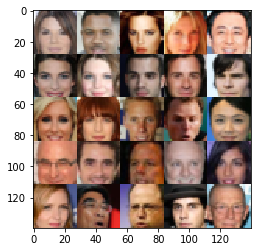

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, name='leanring_rate')

    return inputs, z_data, learn_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3 for celeba and 28x28x1 for mnist
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha= 0.2

    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x512
        
        # Using valid padding for 7*7 to ultimately get to 28*28
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xoutput_dim now
        
        out = tf.tanh(logits)
        
        return out
        

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

  
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    out_channel_dim = data_shape[3]
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each batch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i +1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                # At the end of 100 batches, print the generator output     
                if steps % 100 == 0:
                    show_generator_output(sess, 9, input_z, out_channel_dim, data_image_mode)
                    
        show_generator_output(sess, 9, input_z, out_channel_dim, data_image_mode) 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2196... Generator Loss: 1.7821
Epoch 1/2... Discriminator Loss: 0.1440... Generator Loss: 6.3120
Epoch 1/2... Discriminator Loss: 12.1232... Generator Loss: 0.0000
Epoch 1/2... Discriminator Loss: 0.7752... Generator Loss: 3.2917
Epoch 1/2... Discriminator Loss: 1.3887... Generator Loss: 3.8845
Epoch 1/2... Discriminator Loss: 0.6785... Generator Loss: 2.7041
Epoch 1/2... Discriminator Loss: 0.5634... Generator Loss: 1.6679
Epoch 1/2... Discriminator Loss: 1.0533... Generator Loss: 0.6414
Epoch 1/2... Discriminator Loss: 0.2287... Generator Loss: 2.5034
Epoch 1/2... Discriminator Loss: 0.8860... Generator Loss: 1.4698


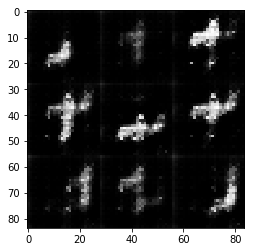

Epoch 1/2... Discriminator Loss: 1.1858... Generator Loss: 0.8148
Epoch 1/2... Discriminator Loss: 1.4245... Generator Loss: 0.3762
Epoch 1/2... Discriminator Loss: 1.3793... Generator Loss: 0.3996
Epoch 1/2... Discriminator Loss: 1.2705... Generator Loss: 0.5335
Epoch 1/2... Discriminator Loss: 1.6638... Generator Loss: 0.2864
Epoch 1/2... Discriminator Loss: 1.3576... Generator Loss: 0.4656
Epoch 1/2... Discriminator Loss: 1.3075... Generator Loss: 0.4224
Epoch 1/2... Discriminator Loss: 1.6943... Generator Loss: 0.3827
Epoch 1/2... Discriminator Loss: 1.3804... Generator Loss: 0.7869
Epoch 1/2... Discriminator Loss: 1.2371... Generator Loss: 1.2728


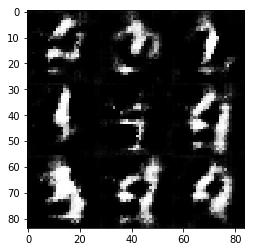

Epoch 1/2... Discriminator Loss: 1.2523... Generator Loss: 0.8042
Epoch 1/2... Discriminator Loss: 1.2308... Generator Loss: 1.8434
Epoch 1/2... Discriminator Loss: 1.3289... Generator Loss: 1.1397
Epoch 1/2... Discriminator Loss: 1.5155... Generator Loss: 1.9745
Epoch 1/2... Discriminator Loss: 1.0833... Generator Loss: 0.8415
Epoch 1/2... Discriminator Loss: 1.4586... Generator Loss: 0.4304
Epoch 1/2... Discriminator Loss: 1.6026... Generator Loss: 0.3162
Epoch 1/2... Discriminator Loss: 1.3451... Generator Loss: 0.4804
Epoch 1/2... Discriminator Loss: 1.3415... Generator Loss: 0.4360
Epoch 1/2... Discriminator Loss: 1.2569... Generator Loss: 0.5908


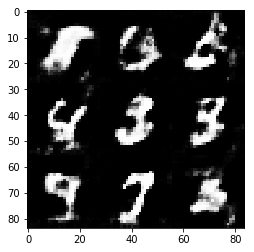

Epoch 1/2... Discriminator Loss: 1.4829... Generator Loss: 0.3766
Epoch 1/2... Discriminator Loss: 1.6722... Generator Loss: 0.3203
Epoch 1/2... Discriminator Loss: 1.4705... Generator Loss: 0.4096
Epoch 1/2... Discriminator Loss: 1.3461... Generator Loss: 0.4509
Epoch 1/2... Discriminator Loss: 1.3823... Generator Loss: 0.4191
Epoch 1/2... Discriminator Loss: 1.4813... Generator Loss: 0.3571
Epoch 1/2... Discriminator Loss: 1.3020... Generator Loss: 0.5468
Epoch 1/2... Discriminator Loss: 1.3547... Generator Loss: 0.4071
Epoch 1/2... Discriminator Loss: 1.5296... Generator Loss: 0.3400
Epoch 1/2... Discriminator Loss: 1.2461... Generator Loss: 0.4876


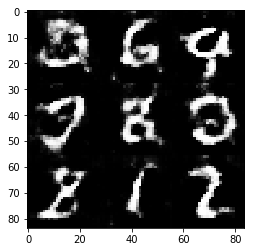

Epoch 1/2... Discriminator Loss: 1.2702... Generator Loss: 1.2436
Epoch 1/2... Discriminator Loss: 1.3783... Generator Loss: 1.0828
Epoch 1/2... Discriminator Loss: 1.1506... Generator Loss: 0.9800
Epoch 1/2... Discriminator Loss: 1.6873... Generator Loss: 0.2717
Epoch 1/2... Discriminator Loss: 1.2919... Generator Loss: 0.4826
Epoch 1/2... Discriminator Loss: 1.4577... Generator Loss: 0.3606
Epoch 1/2... Discriminator Loss: 1.1498... Generator Loss: 1.2549
Epoch 1/2... Discriminator Loss: 1.2420... Generator Loss: 1.2349
Epoch 1/2... Discriminator Loss: 1.3591... Generator Loss: 1.1519
Epoch 1/2... Discriminator Loss: 1.1950... Generator Loss: 0.9819


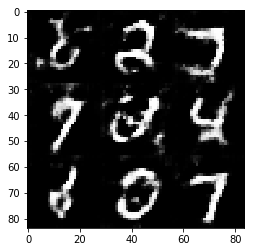

Epoch 1/2... Discriminator Loss: 1.1425... Generator Loss: 0.7324
Epoch 1/2... Discriminator Loss: 1.4193... Generator Loss: 0.4181
Epoch 1/2... Discriminator Loss: 1.5724... Generator Loss: 0.3387
Epoch 1/2... Discriminator Loss: 1.3932... Generator Loss: 0.4201
Epoch 1/2... Discriminator Loss: 1.1273... Generator Loss: 0.7627
Epoch 1/2... Discriminator Loss: 1.7648... Generator Loss: 0.2660
Epoch 1/2... Discriminator Loss: 1.5690... Generator Loss: 0.3125
Epoch 1/2... Discriminator Loss: 1.1664... Generator Loss: 0.6678
Epoch 1/2... Discriminator Loss: 1.3377... Generator Loss: 0.4378
Epoch 1/2... Discriminator Loss: 1.6127... Generator Loss: 0.2866


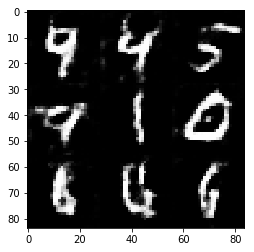

Epoch 1/2... Discriminator Loss: 1.2260... Generator Loss: 0.5733
Epoch 1/2... Discriminator Loss: 1.4997... Generator Loss: 0.3220
Epoch 1/2... Discriminator Loss: 1.2471... Generator Loss: 0.5149
Epoch 1/2... Discriminator Loss: 1.5346... Generator Loss: 0.3578
Epoch 1/2... Discriminator Loss: 1.4898... Generator Loss: 0.3245
Epoch 1/2... Discriminator Loss: 1.1863... Generator Loss: 0.6090
Epoch 1/2... Discriminator Loss: 1.3246... Generator Loss: 0.4532
Epoch 1/2... Discriminator Loss: 1.4663... Generator Loss: 1.3467
Epoch 1/2... Discriminator Loss: 1.1059... Generator Loss: 0.9652
Epoch 1/2... Discriminator Loss: 1.5026... Generator Loss: 1.5388


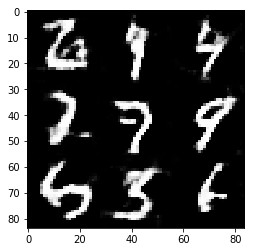

Epoch 1/2... Discriminator Loss: 1.1797... Generator Loss: 1.1315
Epoch 1/2... Discriminator Loss: 1.0583... Generator Loss: 1.2436
Epoch 1/2... Discriminator Loss: 1.5152... Generator Loss: 0.3154
Epoch 1/2... Discriminator Loss: 1.3882... Generator Loss: 0.4685
Epoch 1/2... Discriminator Loss: 1.3370... Generator Loss: 0.4382
Epoch 1/2... Discriminator Loss: 1.0791... Generator Loss: 0.9599
Epoch 1/2... Discriminator Loss: 1.4120... Generator Loss: 0.3687
Epoch 1/2... Discriminator Loss: 1.4549... Generator Loss: 0.3989
Epoch 1/2... Discriminator Loss: 1.3426... Generator Loss: 0.4149
Epoch 1/2... Discriminator Loss: 1.3083... Generator Loss: 0.4517


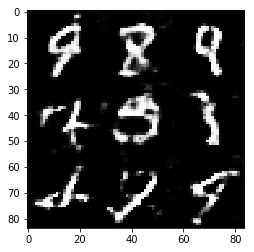

Epoch 1/2... Discriminator Loss: 1.7496... Generator Loss: 0.2482
Epoch 1/2... Discriminator Loss: 0.9748... Generator Loss: 0.8119
Epoch 1/2... Discriminator Loss: 1.4546... Generator Loss: 0.3774
Epoch 1/2... Discriminator Loss: 1.6643... Generator Loss: 0.2567
Epoch 1/2... Discriminator Loss: 1.4853... Generator Loss: 0.3268
Epoch 1/2... Discriminator Loss: 1.5085... Generator Loss: 0.3557
Epoch 1/2... Discriminator Loss: 1.1531... Generator Loss: 0.5494
Epoch 1/2... Discriminator Loss: 1.2555... Generator Loss: 1.3271
Epoch 1/2... Discriminator Loss: 1.2121... Generator Loss: 1.3023
Epoch 1/2... Discriminator Loss: 0.8687... Generator Loss: 1.2160


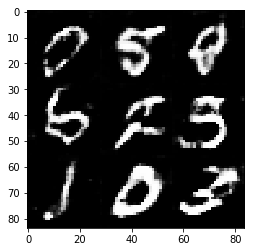

Epoch 1/2... Discriminator Loss: 1.3846... Generator Loss: 1.4022
Epoch 1/2... Discriminator Loss: 1.1514... Generator Loss: 1.4155
Epoch 1/2... Discriminator Loss: 1.2678... Generator Loss: 1.3201
Epoch 2/2... Discriminator Loss: 1.1712... Generator Loss: 1.6015
Epoch 2/2... Discriminator Loss: 1.3812... Generator Loss: 1.4595
Epoch 2/2... Discriminator Loss: 1.2949... Generator Loss: 1.6903
Epoch 2/2... Discriminator Loss: 0.9398... Generator Loss: 0.7151
Epoch 2/2... Discriminator Loss: 1.1858... Generator Loss: 0.6115
Epoch 2/2... Discriminator Loss: 1.1824... Generator Loss: 0.5462
Epoch 2/2... Discriminator Loss: 1.1566... Generator Loss: 0.6690


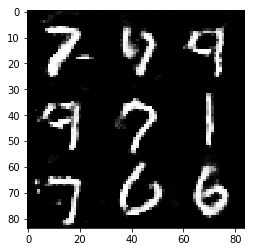

Epoch 2/2... Discriminator Loss: 1.1128... Generator Loss: 0.6305
Epoch 2/2... Discriminator Loss: 1.4486... Generator Loss: 0.3995
Epoch 2/2... Discriminator Loss: 1.6514... Generator Loss: 0.2681
Epoch 2/2... Discriminator Loss: 1.2582... Generator Loss: 0.4286
Epoch 2/2... Discriminator Loss: 1.7971... Generator Loss: 0.2441
Epoch 2/2... Discriminator Loss: 1.2846... Generator Loss: 0.4585
Epoch 2/2... Discriminator Loss: 1.0364... Generator Loss: 0.7742
Epoch 2/2... Discriminator Loss: 1.5119... Generator Loss: 0.4548
Epoch 2/2... Discriminator Loss: 1.5282... Generator Loss: 0.3647
Epoch 2/2... Discriminator Loss: 1.2588... Generator Loss: 1.3767


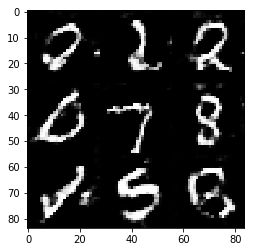

Epoch 2/2... Discriminator Loss: 0.9441... Generator Loss: 1.3612
Epoch 2/2... Discriminator Loss: 1.6906... Generator Loss: 0.2885
Epoch 2/2... Discriminator Loss: 1.2554... Generator Loss: 0.5061
Epoch 2/2... Discriminator Loss: 1.2021... Generator Loss: 0.4842
Epoch 2/2... Discriminator Loss: 1.4555... Generator Loss: 0.3505
Epoch 2/2... Discriminator Loss: 1.3463... Generator Loss: 0.4266
Epoch 2/2... Discriminator Loss: 1.2694... Generator Loss: 0.4434
Epoch 2/2... Discriminator Loss: 0.8632... Generator Loss: 1.3634
Epoch 2/2... Discriminator Loss: 1.2200... Generator Loss: 0.5472
Epoch 2/2... Discriminator Loss: 1.2816... Generator Loss: 0.4681


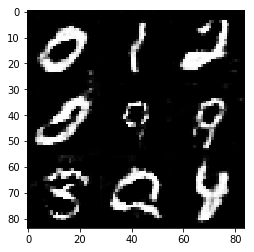

Epoch 2/2... Discriminator Loss: 1.0006... Generator Loss: 0.7054
Epoch 2/2... Discriminator Loss: 1.5704... Generator Loss: 0.3113
Epoch 2/2... Discriminator Loss: 0.9997... Generator Loss: 0.6726
Epoch 2/2... Discriminator Loss: 1.7633... Generator Loss: 0.2423
Epoch 2/2... Discriminator Loss: 1.6383... Generator Loss: 0.2817
Epoch 2/2... Discriminator Loss: 1.5054... Generator Loss: 0.3441
Epoch 2/2... Discriminator Loss: 1.6746... Generator Loss: 0.2810
Epoch 2/2... Discriminator Loss: 1.5055... Generator Loss: 0.3739
Epoch 2/2... Discriminator Loss: 1.6663... Generator Loss: 0.2740
Epoch 2/2... Discriminator Loss: 2.0271... Generator Loss: 0.1917


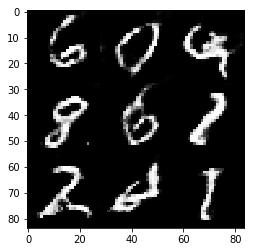

Epoch 2/2... Discriminator Loss: 1.3586... Generator Loss: 0.4196
Epoch 2/2... Discriminator Loss: 1.0869... Generator Loss: 0.6013
Epoch 2/2... Discriminator Loss: 1.0155... Generator Loss: 0.6780
Epoch 2/2... Discriminator Loss: 0.9110... Generator Loss: 1.1683
Epoch 2/2... Discriminator Loss: 0.7802... Generator Loss: 1.6074
Epoch 2/2... Discriminator Loss: 1.0925... Generator Loss: 2.2850
Epoch 2/2... Discriminator Loss: 1.1750... Generator Loss: 0.5463
Epoch 2/2... Discriminator Loss: 1.1900... Generator Loss: 0.4945
Epoch 2/2... Discriminator Loss: 1.1740... Generator Loss: 0.6390
Epoch 2/2... Discriminator Loss: 0.7654... Generator Loss: 1.3958


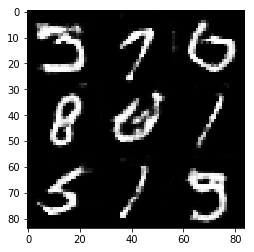

Epoch 2/2... Discriminator Loss: 1.0226... Generator Loss: 1.4474
Epoch 2/2... Discriminator Loss: 0.7547... Generator Loss: 1.0739
Epoch 2/2... Discriminator Loss: 1.2387... Generator Loss: 0.6112
Epoch 2/2... Discriminator Loss: 1.8161... Generator Loss: 0.2459
Epoch 2/2... Discriminator Loss: 1.8298... Generator Loss: 0.2484
Epoch 2/2... Discriminator Loss: 0.7653... Generator Loss: 1.0658
Epoch 2/2... Discriminator Loss: 1.0895... Generator Loss: 1.5781
Epoch 2/2... Discriminator Loss: 0.9278... Generator Loss: 1.4133
Epoch 2/2... Discriminator Loss: 1.2546... Generator Loss: 0.4910
Epoch 2/2... Discriminator Loss: 1.7475... Generator Loss: 0.2867


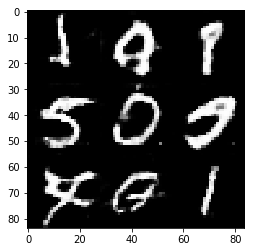

Epoch 2/2... Discriminator Loss: 1.9128... Generator Loss: 0.2344
Epoch 2/2... Discriminator Loss: 1.1051... Generator Loss: 0.6565
Epoch 2/2... Discriminator Loss: 1.3695... Generator Loss: 0.4582
Epoch 2/2... Discriminator Loss: 0.7285... Generator Loss: 1.0789
Epoch 2/2... Discriminator Loss: 1.2133... Generator Loss: 0.5281
Epoch 2/2... Discriminator Loss: 1.1880... Generator Loss: 0.5645
Epoch 2/2... Discriminator Loss: 1.8309... Generator Loss: 0.2638
Epoch 2/2... Discriminator Loss: 1.7547... Generator Loss: 0.2767
Epoch 2/2... Discriminator Loss: 0.7563... Generator Loss: 2.7371
Epoch 2/2... Discriminator Loss: 1.0355... Generator Loss: 0.6733


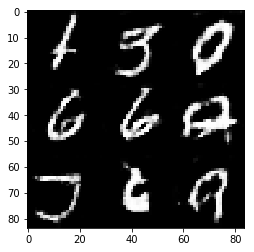

Epoch 2/2... Discriminator Loss: 0.5186... Generator Loss: 1.6322
Epoch 2/2... Discriminator Loss: 0.6740... Generator Loss: 1.8754
Epoch 2/2... Discriminator Loss: 1.3021... Generator Loss: 0.4729
Epoch 2/2... Discriminator Loss: 0.8426... Generator Loss: 0.8654
Epoch 2/2... Discriminator Loss: 1.1320... Generator Loss: 0.5237
Epoch 2/2... Discriminator Loss: 1.0312... Generator Loss: 0.7428
Epoch 2/2... Discriminator Loss: 1.9505... Generator Loss: 0.2380
Epoch 2/2... Discriminator Loss: 1.0804... Generator Loss: 0.6003
Epoch 2/2... Discriminator Loss: 1.5067... Generator Loss: 0.3537
Epoch 2/2... Discriminator Loss: 0.8641... Generator Loss: 1.2682


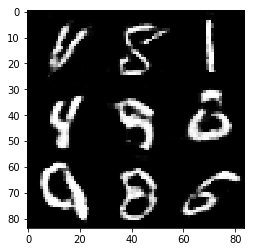

Epoch 2/2... Discriminator Loss: 2.1856... Generator Loss: 3.0172
Epoch 2/2... Discriminator Loss: 1.0339... Generator Loss: 0.9591
Epoch 2/2... Discriminator Loss: 1.3549... Generator Loss: 0.4137
Epoch 2/2... Discriminator Loss: 0.9903... Generator Loss: 1.3406
Epoch 2/2... Discriminator Loss: 1.0942... Generator Loss: 2.2455
Epoch 2/2... Discriminator Loss: 1.1507... Generator Loss: 2.6042
Epoch 2/2... Discriminator Loss: 0.5259... Generator Loss: 1.7913
Epoch 2/2... Discriminator Loss: 0.7994... Generator Loss: 0.8488
Epoch 2/2... Discriminator Loss: 0.8050... Generator Loss: 3.2810
Epoch 2/2... Discriminator Loss: 0.9465... Generator Loss: 1.9853


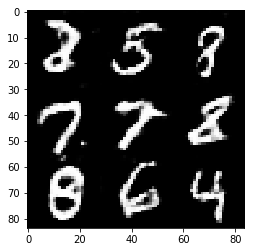

Epoch 2/2... Discriminator Loss: 1.3207... Generator Loss: 0.4956
Epoch 2/2... Discriminator Loss: 1.6060... Generator Loss: 0.3187
Epoch 2/2... Discriminator Loss: 0.5031... Generator Loss: 1.2855
Epoch 2/2... Discriminator Loss: 3.4781... Generator Loss: 4.6545
Epoch 2/2... Discriminator Loss: 0.9705... Generator Loss: 1.0117
Epoch 2/2... Discriminator Loss: 0.8794... Generator Loss: 1.3643
Epoch 2/2... Discriminator Loss: 1.4317... Generator Loss: 2.7235


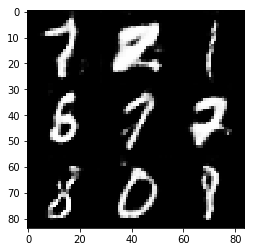

In [12]:
batch_size = 64
z_dim = 126
learning_rate = 0.0009
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0801... Generator Loss: 5.4732
Epoch 1/1... Discriminator Loss: 0.2047... Generator Loss: 4.7966
Epoch 1/1... Discriminator Loss: 2.3354... Generator Loss: 0.1320
Epoch 1/1... Discriminator Loss: 1.6665... Generator Loss: 5.6382
Epoch 1/1... Discriminator Loss: 0.7433... Generator Loss: 2.9810
Epoch 1/1... Discriminator Loss: 1.5856... Generator Loss: 0.4460
Epoch 1/1... Discriminator Loss: 0.6607... Generator Loss: 1.4682
Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 0.7661... Generator Loss: 1.0716
Epoch 1/1... Discriminator Loss: 0.1515... Generator Loss: 3.4201


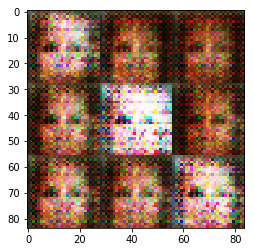

Epoch 1/1... Discriminator Loss: 0.7171... Generator Loss: 3.4605
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.4240
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.6853... Generator Loss: 0.2808
Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 3.2001
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 0.9180
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 0.6577... Generator Loss: 1.5401
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 1.4473
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.7371


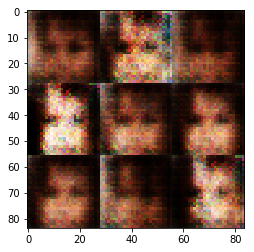

Epoch 1/1... Discriminator Loss: 1.5623... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 1.0400
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.6663... Generator Loss: 0.3824
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 1.1209
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.5067
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 0.8760


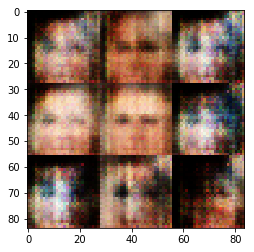

Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 1.0958
Epoch 1/1... Discriminator Loss: 1.5078... Generator Loss: 0.4955
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.4808
Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 1.0047
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.3531
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 1.2050
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 1.0640
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.6187


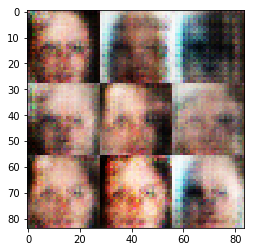

Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.5846
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.5978
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.4722
Epoch 1/1... Discriminator Loss: 0.6407... Generator Loss: 1.1897
Epoch 1/1... Discriminator Loss: 1.7079... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.6030
Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 0.8816


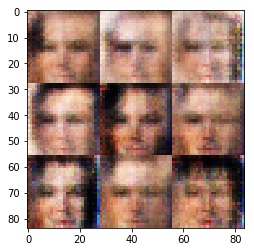

Epoch 1/1... Discriminator Loss: 1.5752... Generator Loss: 0.3918
Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.5750
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.5962
Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 1.0558
Epoch 1/1... Discriminator Loss: 1.0028... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 0.9887
Epoch 1/1... Discriminator Loss: 1.6043... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 0.8460


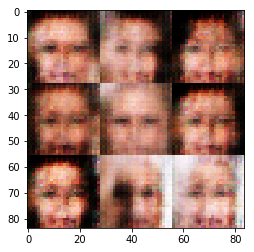

Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.4983
Epoch 1/1... Discriminator Loss: 1.4967... Generator Loss: 1.7616
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 0.9386
Epoch 1/1... Discriminator Loss: 0.9857... Generator Loss: 1.6785
Epoch 1/1... Discriminator Loss: 1.8048... Generator Loss: 0.2611
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 0.5260
Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.4963
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.6397


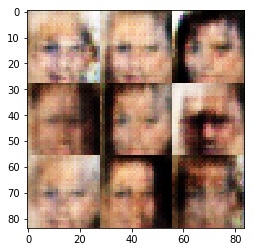

Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.3687
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 1.4568
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 1.0827
Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 1.0519
Epoch 1/1... Discriminator Loss: 1.6457... Generator Loss: 0.2542
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 1.4326


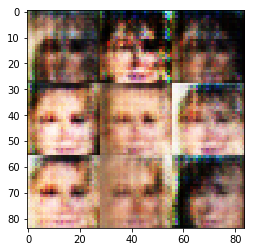

Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.3888
Epoch 1/1... Discriminator Loss: 0.7780... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 0.7770... Generator Loss: 1.1074
Epoch 1/1... Discriminator Loss: 1.0517... Generator Loss: 1.5693
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.4587
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.5865... Generator Loss: 1.4227
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.5530
Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 0.8022


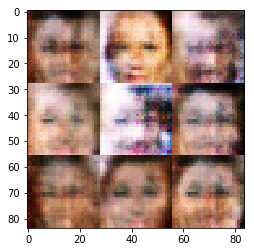

Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.3666
Epoch 1/1... Discriminator Loss: 1.9274... Generator Loss: 1.3406
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 1.1546
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.8274... Generator Loss: 0.2381
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.5692
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.8395


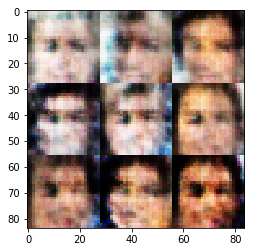

Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 0.6043
Epoch 1/1... Discriminator Loss: 1.7097... Generator Loss: 0.3090
Epoch 1/1... Discriminator Loss: 1.5716... Generator Loss: 0.5297
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 1.0715
Epoch 1/1... Discriminator Loss: 1.5294... Generator Loss: 0.5806
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 1.0458
Epoch 1/1... Discriminator Loss: 1.6274... Generator Loss: 0.4351


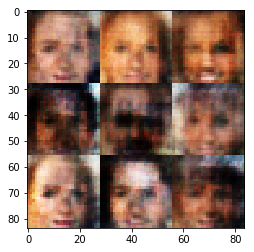

Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.4307
Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.5536
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 1.3257
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.4905
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 1.5511


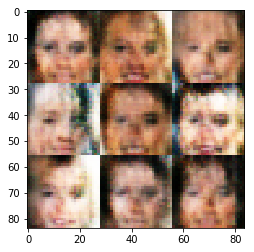

Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.5641
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 1.1179
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.7559... Generator Loss: 0.3512
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 0.9045
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.5923


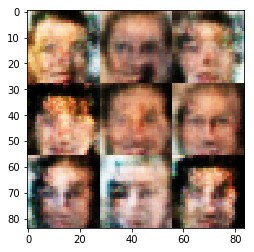

Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 0.4747
Epoch 1/1... Discriminator Loss: 1.5225... Generator Loss: 1.4873
Epoch 1/1... Discriminator Loss: 1.6245... Generator Loss: 0.5452
Epoch 1/1... Discriminator Loss: 1.5348... Generator Loss: 0.6235
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.5333... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 1.2104
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.4741
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 1.3139


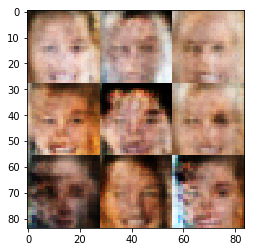

Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.5380
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 1.6915
Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.9286
Epoch 1/1... Discriminator Loss: 1.6994... Generator Loss: 0.2968
Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.5900
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.4356


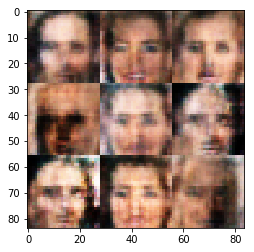

Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 1.0925
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 1.6646... Generator Loss: 0.2558
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.3667
Epoch 1/1... Discriminator Loss: 1.7088... Generator Loss: 1.2904
Epoch 1/1... Discriminator Loss: 1.6185... Generator Loss: 0.4063
Epoch 1/1... Discriminator Loss: 1.0295... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 0.5165
Epoch 1/1... Discriminator Loss: 1.6834... Generator Loss: 0.4052
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.5697


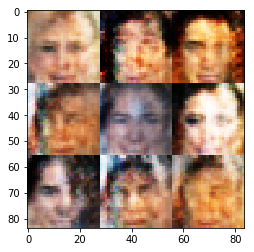

Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.9510
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.5110
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.5252... Generator Loss: 0.4311
Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 1.3223
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.4913
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 0.5875
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 0.8015


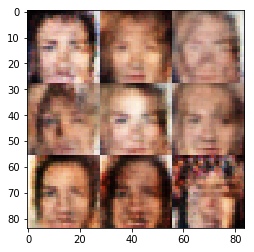

Epoch 1/1... Discriminator Loss: 1.5353... Generator Loss: 0.4795
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.7586... Generator Loss: 0.2339
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.5581
Epoch 1/1... Discriminator Loss: 1.5893... Generator Loss: 0.2932
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.5272
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 1.0076
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.6251


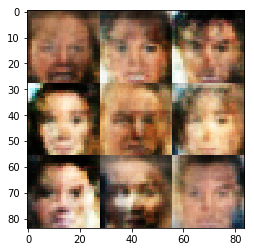

Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 1.3493
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 1.3880
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.9540
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.0806... Generator Loss: 0.9752
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.5996
Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 0.6893


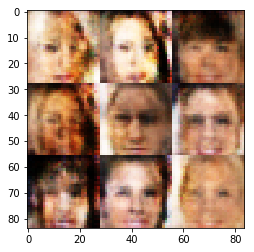

Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 0.8021... Generator Loss: 1.0809
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.5295
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.5303... Generator Loss: 0.5287
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 0.6094


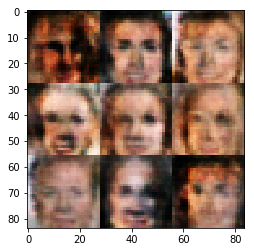

Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 0.6004
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.5020
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 1.0096
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.3390
Epoch 1/1... Discriminator Loss: 1.5543... Generator Loss: 0.3419


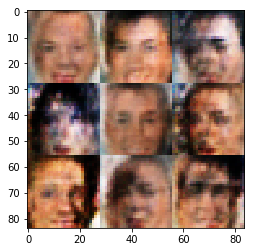

Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.5451
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 1.4629
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.9369
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.4531
Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 0.4879
Epoch 1/1... Discriminator Loss: 1.6624... Generator Loss: 0.3378
Epoch 1/1... Discriminator Loss: 1.5329... Generator Loss: 0.3941
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.9057


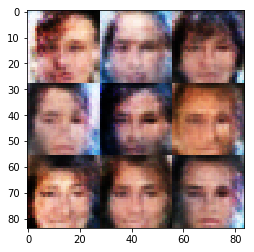

Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 1.0611
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.5663
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.3749
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.5217
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.4570
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 1.1058
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 0.6194


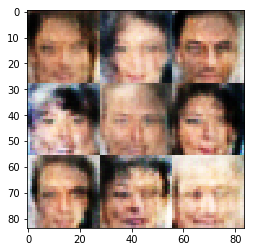

Epoch 1/1... Discriminator Loss: 0.9711... Generator Loss: 1.0501
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 0.5682
Epoch 1/1... Discriminator Loss: 0.7878... Generator Loss: 1.0446
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 1.2869
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.8651
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.7121... Generator Loss: 0.2991
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.9859
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.6556


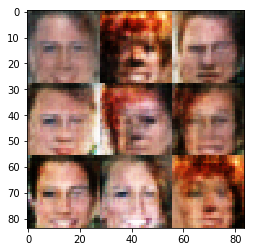

Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 0.9656
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.4249
Epoch 1/1... Discriminator Loss: 1.4732... Generator Loss: 1.7250
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.4821
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 0.9129... Generator Loss: 0.7640


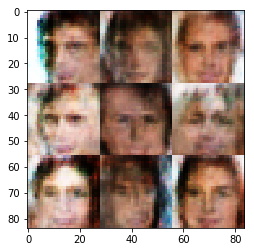

Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.4005
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.5471
Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 1.0715
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 0.5894
Epoch 1/1... Discriminator Loss: 0.9941... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.4423
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 1.2104


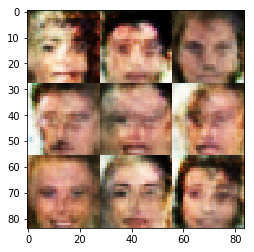

Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.5196
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 0.9572
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.9227
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.7405


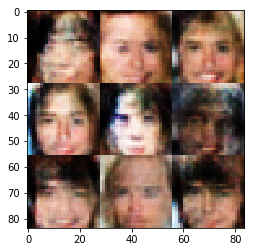

Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.5459
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 0.9447... Generator Loss: 1.3233
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 0.9595... Generator Loss: 0.9500
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.9716
Epoch 1/1... Discriminator Loss: 0.9260... Generator Loss: 1.0880
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 1.2901


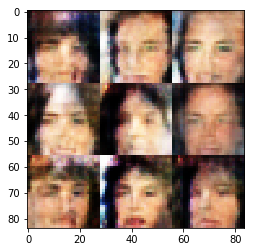

Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.5363
Epoch 1/1... Discriminator Loss: 0.9309... Generator Loss: 1.1892
Epoch 1/1... Discriminator Loss: 1.7139... Generator Loss: 1.6594
Epoch 1/1... Discriminator Loss: 0.9951... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.5582... Generator Loss: 0.3695
Epoch 1/1... Discriminator Loss: 1.2077... Generator Loss: 0.6725


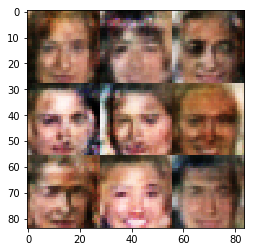

Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.4490
Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 0.5591
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.9433
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.4856
Epoch 1/1... Discriminator Loss: 1.9132... Generator Loss: 0.2892
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 0.4311


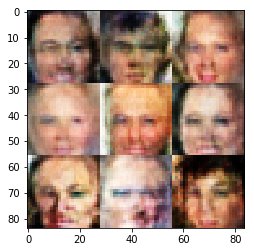

Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.4077
Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.4629
Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 0.4064
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 0.5919
Epoch 1/1... Discriminator Loss: 1.6055... Generator Loss: 0.3029
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.4657


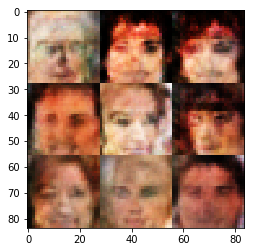

Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 1.3303
Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 0.9844
Epoch 1/1... Discriminator Loss: 0.9132... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 1.3189
Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 1.1666


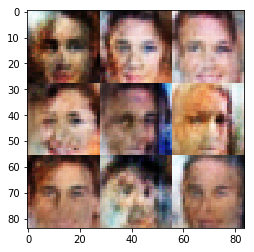

Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.4612
Epoch 1/1... Discriminator Loss: 0.8448... Generator Loss: 1.3860
Epoch 1/1... Discriminator Loss: 1.5368... Generator Loss: 0.4605
Epoch 1/1... Discriminator Loss: 0.8960... Generator Loss: 1.1300
Epoch 1/1... Discriminator Loss: 1.6033... Generator Loss: 0.3207
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.5590... Generator Loss: 0.3852
Epoch 1/1... Discriminator Loss: 0.8718... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 1.0146
Epoch 1/1... Discriminator Loss: 0.8437... Generator Loss: 1.0438


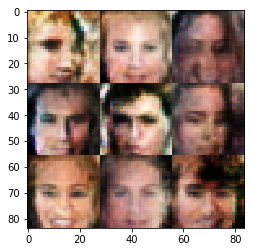

Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.4283
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 1.0683... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 1.0715
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.4553
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.4623
Epoch 1/1... Discriminator Loss: 1.6551... Generator Loss: 0.2666
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 0.9939


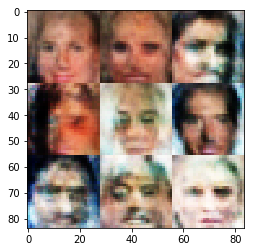

Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 0.9806
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.5449
Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.3529
Epoch 1/1... Discriminator Loss: 2.0077... Generator Loss: 0.3505
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.4156
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 0.7938... Generator Loss: 1.4822
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 0.7279


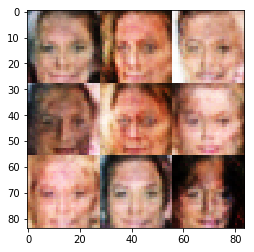

Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 0.8733... Generator Loss: 1.2697
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 1.5171
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.5534
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.5842
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.5303
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 0.8882... Generator Loss: 1.4560
Epoch 1/1... Discriminator Loss: 0.9153... Generator Loss: 1.0971
Epoch 1/1... Discriminator Loss: 0.8261... Generator Loss: 2.0072


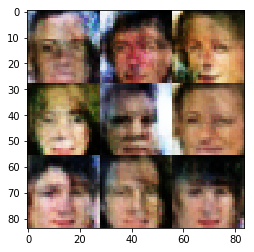

Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.3501
Epoch 1/1... Discriminator Loss: 0.8876... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.8574... Generator Loss: 0.2418
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.4200
Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 0.3923
Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 1.2380
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.5363
Epoch 1/1... Discriminator Loss: 1.8645... Generator Loss: 0.2621
Epoch 1/1... Discriminator Loss: 0.7856... Generator Loss: 1.1906


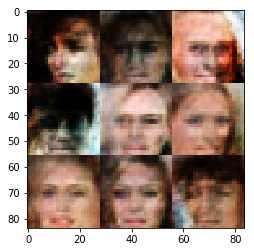

Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.4910
Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 0.9149
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 1.0618
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 1.0869


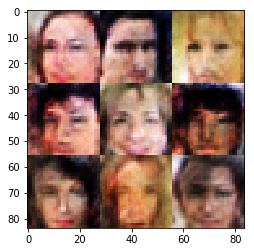

Epoch 1/1... Discriminator Loss: 1.8300... Generator Loss: 0.1944
Epoch 1/1... Discriminator Loss: 2.1377... Generator Loss: 2.1354
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.5537
Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 1.1368
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.4395
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.5430
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.5434
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.4004


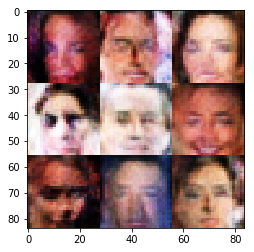

Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.4889
Epoch 1/1... Discriminator Loss: 1.5198... Generator Loss: 1.7315
Epoch 1/1... Discriminator Loss: 1.7097... Generator Loss: 0.2728
Epoch 1/1... Discriminator Loss: 1.0314... Generator Loss: 0.9967
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.5403
Epoch 1/1... Discriminator Loss: 0.8674... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 0.9747... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.7284


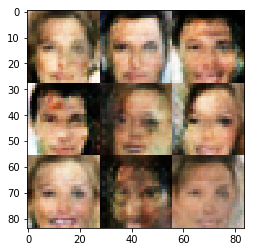

Epoch 1/1... Discriminator Loss: 1.0948... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 0.9135... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.3623
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.4566
Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 1.2531
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 1.5892
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 2.1104
Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.4648
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.6638... Generator Loss: 0.2320


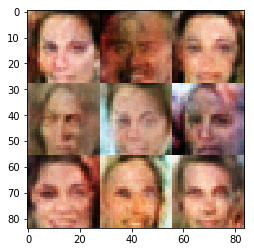

Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.0345... Generator Loss: 0.5962
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.4680
Epoch 1/1... Discriminator Loss: 0.8191... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 2.3995... Generator Loss: 2.3867
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 1.5390... Generator Loss: 0.3367
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.0865... Generator Loss: 0.6040
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.8480


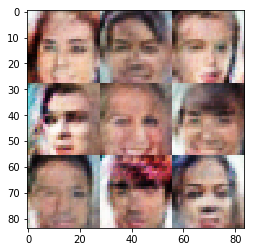

Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.4977
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.3983
Epoch 1/1... Discriminator Loss: 1.1297... Generator Loss: 0.5988
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.3394
Epoch 1/1... Discriminator Loss: 0.5225... Generator Loss: 2.4664
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.4811... Generator Loss: 0.4309
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.5529


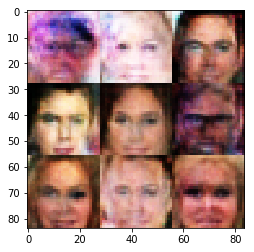

Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 0.9838
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 0.9256
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 1.7253
Epoch 1/1... Discriminator Loss: 1.8892... Generator Loss: 0.2207
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 1.0088
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 1.9334
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.3771
Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 0.4901
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.3931
Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.4363


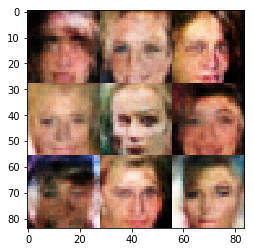

Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 1.1486
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.4549
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 0.9469... Generator Loss: 0.9169
Epoch 1/1... Discriminator Loss: 1.6436... Generator Loss: 0.4594
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.5782
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 0.7550


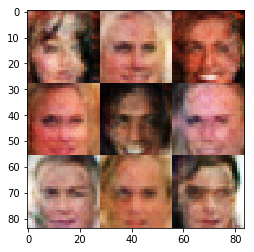

Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.4179
Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 1.6104... Generator Loss: 0.3349
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 1.1253
Epoch 1/1... Discriminator Loss: 0.7560... Generator Loss: 1.0042
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 0.5476
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.6208
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.4473
Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 0.3654


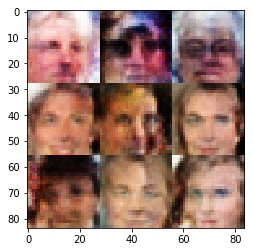

Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 0.9520
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.5126
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.6083
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.3956
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.4348
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.5330
Epoch 1/1... Discriminator Loss: 0.9241... Generator Loss: 1.1273
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.3363
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.4280


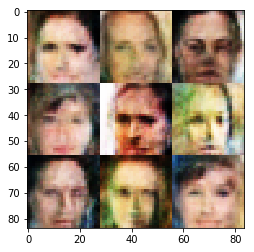

Epoch 1/1... Discriminator Loss: 1.6734... Generator Loss: 0.2458
Epoch 1/1... Discriminator Loss: 1.0210... Generator Loss: 1.2980
Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.5419
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.4791
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.5682
Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 1.2370
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 0.4874
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.5319
Epoch 1/1... Discriminator Loss: 1.5499... Generator Loss: 0.4886


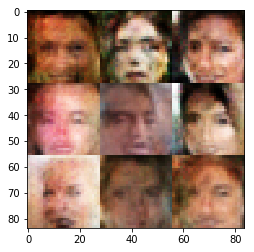

Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.3959
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.4496
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.5789
Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 0.5787
Epoch 1/1... Discriminator Loss: 0.5495... Generator Loss: 1.3923
Epoch 1/1... Discriminator Loss: 0.8244... Generator Loss: 1.2596
Epoch 1/1... Discriminator Loss: 1.6608... Generator Loss: 0.3050
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.3104
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 0.7331


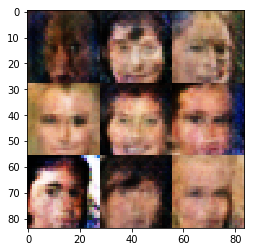

Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.4952
Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.4635
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.4419
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 0.5839
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.5171
Epoch 1/1... Discriminator Loss: 0.8457... Generator Loss: 0.7869


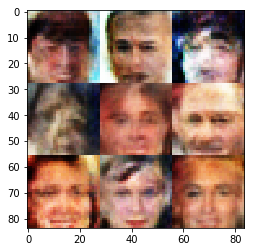

Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.4861
Epoch 1/1... Discriminator Loss: 1.0944... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.0720... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.6191... Generator Loss: 0.3347
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.3655
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.4712
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.4941
Epoch 1/1... Discriminator Loss: 2.0630... Generator Loss: 3.3633


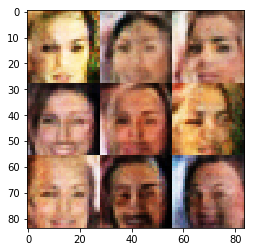

Epoch 1/1... Discriminator Loss: 0.6037... Generator Loss: 1.2329
Epoch 1/1... Discriminator Loss: 1.8935... Generator Loss: 0.2256
Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 0.5331
Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 0.8543
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 0.8914... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 1.0655
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.4374


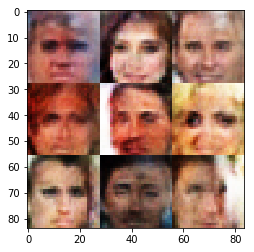

Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.3830
Epoch 1/1... Discriminator Loss: 0.7831... Generator Loss: 1.4644
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.5254
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.3732
Epoch 1/1... Discriminator Loss: 1.6687... Generator Loss: 0.5180
Epoch 1/1... Discriminator Loss: 2.2671... Generator Loss: 0.1367
Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 0.5535
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 1.0380
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.4708
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 1.3362


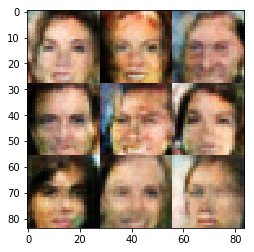

Epoch 1/1... Discriminator Loss: 0.7056... Generator Loss: 1.0749
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 1.3646
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.5401
Epoch 1/1... Discriminator Loss: 0.9512... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.4522
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.3962
Epoch 1/1... Discriminator Loss: 0.8810... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.3416
Epoch 1/1... Discriminator Loss: 0.8087... Generator Loss: 1.7847


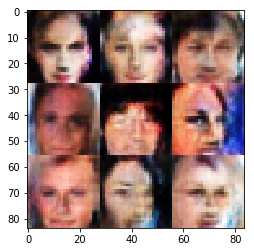

Epoch 1/1... Discriminator Loss: 0.9431... Generator Loss: 0.6172
Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.4890... Generator Loss: 0.3827
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 0.4659
Epoch 1/1... Discriminator Loss: 1.6429... Generator Loss: 0.3799
Epoch 1/1... Discriminator Loss: 0.6138... Generator Loss: 1.5269
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 0.7927... Generator Loss: 0.9242


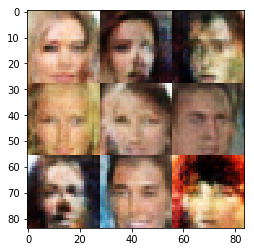

Epoch 1/1... Discriminator Loss: 0.8738... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 0.9771... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 0.5881... Generator Loss: 2.9913
Epoch 1/1... Discriminator Loss: 1.6210... Generator Loss: 0.3369
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.3527
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 1.1487
Epoch 1/1... Discriminator Loss: 1.0688... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.5109


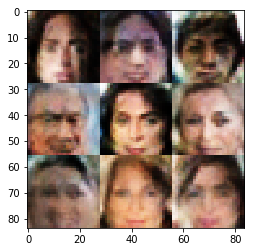

Epoch 1/1... Discriminator Loss: 1.5144... Generator Loss: 0.3067
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.6500... Generator Loss: 0.2704
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.5822
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.4011
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.5741
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.8427


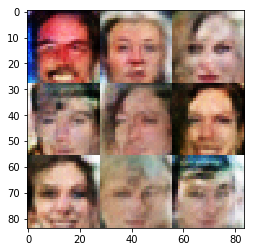

Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 1.1152
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.4505
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.5282
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 1.4078
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 0.4856
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 1.0585
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.5192... Generator Loss: 0.3666


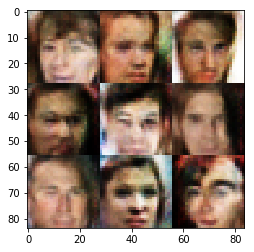

Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.4758
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.4137
Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 0.7692... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 0.8862... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 1.4741
Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.3443
Epoch 1/1... Discriminator Loss: 0.7143... Generator Loss: 1.0830


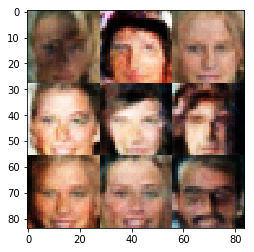

Epoch 1/1... Discriminator Loss: 0.5260... Generator Loss: 1.5674
Epoch 1/1... Discriminator Loss: 0.6277... Generator Loss: 1.0409
Epoch 1/1... Discriminator Loss: 1.5756... Generator Loss: 0.3692
Epoch 1/1... Discriminator Loss: 1.0392... Generator Loss: 0.5660
Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.4826
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 0.6012


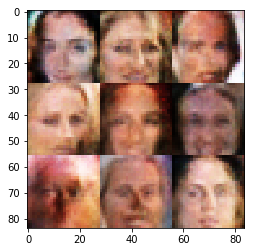

Epoch 1/1... Discriminator Loss: 1.1333... Generator Loss: 0.6073
Epoch 1/1... Discriminator Loss: 0.7267... Generator Loss: 1.6661
Epoch 1/1... Discriminator Loss: 0.9492... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.7027... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 1.0503
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 0.9827... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 0.9158


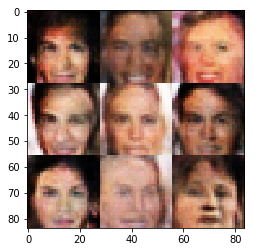

Epoch 1/1... Discriminator Loss: 0.9607... Generator Loss: 1.1411
Epoch 1/1... Discriminator Loss: 1.0177... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.0993... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 0.4560
Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 0.9443
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.1104... Generator Loss: 1.1401
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 1.0248
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 1.0823


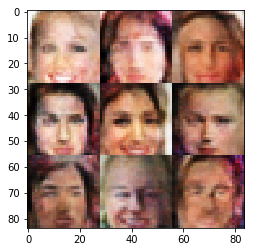

Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 0.5540
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 0.5177
Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.4319
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.4405
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.4368
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.4615
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.4434


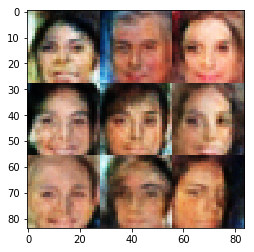

Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 0.8689... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 0.9764
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.7119... Generator Loss: 0.2473
Epoch 1/1... Discriminator Loss: 1.2071... Generator Loss: 0.5690
Epoch 1/1... Discriminator Loss: 1.5899... Generator Loss: 0.2711
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 0.4842
Epoch 1/1... Discriminator Loss: 1.0009... Generator Loss: 0.9715


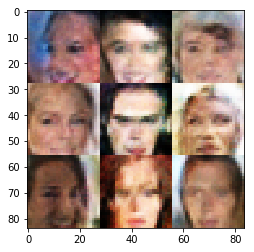

Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 1.1602
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.5420
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.4289
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 0.9983
Epoch 1/1... Discriminator Loss: 0.9425... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 0.7274... Generator Loss: 1.2235
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.3541
Epoch 1/1... Discriminator Loss: 0.7174... Generator Loss: 0.9442


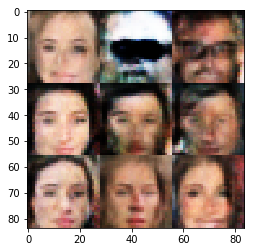

Epoch 1/1... Discriminator Loss: 0.9643... Generator Loss: 1.0531
Epoch 1/1... Discriminator Loss: 2.8337... Generator Loss: 0.0724
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.4784
Epoch 1/1... Discriminator Loss: 0.4824... Generator Loss: 1.7666
Epoch 1/1... Discriminator Loss: 0.5515... Generator Loss: 1.6774
Epoch 1/1... Discriminator Loss: 0.9953... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.4185
Epoch 1/1... Discriminator Loss: 1.5804... Generator Loss: 0.5868
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.5517
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 1.2649


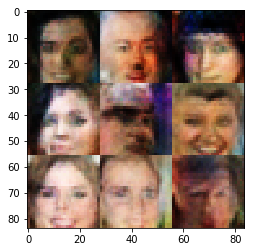

Epoch 1/1... Discriminator Loss: 1.4974... Generator Loss: 0.3471
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 0.6435
Epoch 1/1... Discriminator Loss: 1.5897... Generator Loss: 0.3444
Epoch 1/1... Discriminator Loss: 0.9941... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.9284
Epoch 1/1... Discriminator Loss: 1.0590... Generator Loss: 1.0847
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 0.9760... Generator Loss: 0.9581
Epoch 1/1... Discriminator Loss: 1.8268... Generator Loss: 0.2681
Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 0.7846


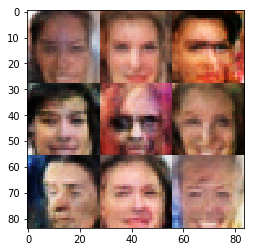

Epoch 1/1... Discriminator Loss: 1.0267... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 0.8881... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 0.5568
Epoch 1/1... Discriminator Loss: 0.6086... Generator Loss: 0.9672
Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 0.4873
Epoch 1/1... Discriminator Loss: 1.1047... Generator Loss: 0.5119
Epoch 1/1... Discriminator Loss: 0.6787... Generator Loss: 2.8617
Epoch 1/1... Discriminator Loss: 0.9624... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 0.9079... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 0.6315


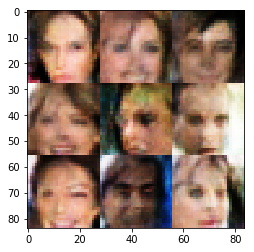

Epoch 1/1... Discriminator Loss: 1.5903... Generator Loss: 0.5059
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 0.5380
Epoch 1/1... Discriminator Loss: 0.5756... Generator Loss: 0.9726
Epoch 1/1... Discriminator Loss: 1.8071... Generator Loss: 0.2021
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 0.5412
Epoch 1/1... Discriminator Loss: 1.0212... Generator Loss: 2.0994
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.3837
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.5465
Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 0.7942... Generator Loss: 0.8803


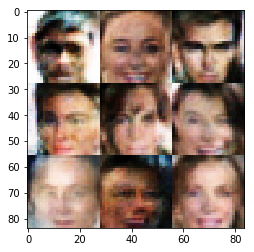

Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 0.8091... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.3901
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 0.4942
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.4303
Epoch 1/1... Discriminator Loss: 0.3405... Generator Loss: 1.5463
Epoch 1/1... Discriminator Loss: 1.7078... Generator Loss: 0.3199
Epoch 1/1... Discriminator Loss: 0.7123... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.8640


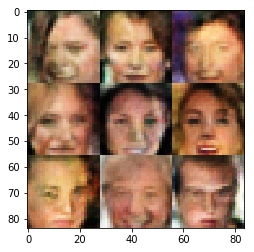

Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.4596
Epoch 1/1... Discriminator Loss: 0.5419... Generator Loss: 1.4029
Epoch 1/1... Discriminator Loss: 1.5818... Generator Loss: 2.9959
Epoch 1/1... Discriminator Loss: 0.6155... Generator Loss: 3.6785
Epoch 1/1... Discriminator Loss: 0.5609... Generator Loss: 2.1483
Epoch 1/1... Discriminator Loss: 0.6904... Generator Loss: 1.1653
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 0.6487... Generator Loss: 1.2871
Epoch 1/1... Discriminator Loss: 0.2915... Generator Loss: 1.6838


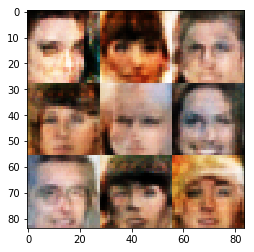

Epoch 1/1... Discriminator Loss: 1.1289... Generator Loss: 0.5416
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.5170
Epoch 1/1... Discriminator Loss: 0.7701... Generator Loss: 1.0240
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.4053
Epoch 1/1... Discriminator Loss: 0.5592... Generator Loss: 1.6502
Epoch 1/1... Discriminator Loss: 0.5411... Generator Loss: 1.1438
Epoch 1/1... Discriminator Loss: 0.5515... Generator Loss: 1.7749
Epoch 1/1... Discriminator Loss: 0.6358... Generator Loss: 3.8786
Epoch 1/1... Discriminator Loss: 0.9719... Generator Loss: 1.1274
Epoch 1/1... Discriminator Loss: 1.7386... Generator Loss: 0.2346


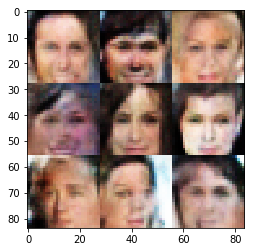

Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.3434
Epoch 1/1... Discriminator Loss: 1.5305... Generator Loss: 2.9620
Epoch 1/1... Discriminator Loss: 0.4934... Generator Loss: 1.5652
Epoch 1/1... Discriminator Loss: 0.3230... Generator Loss: 2.1518
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 0.3766... Generator Loss: 1.6853
Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 1.2514
Epoch 1/1... Discriminator Loss: 0.8308... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 0.3171... Generator Loss: 1.5511
Epoch 1/1... Discriminator Loss: 0.4916... Generator Loss: 1.3925


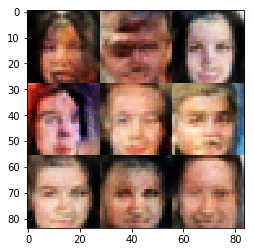

Epoch 1/1... Discriminator Loss: 0.4441... Generator Loss: 2.1922
Epoch 1/1... Discriminator Loss: 0.3029... Generator Loss: 2.4827
Epoch 1/1... Discriminator Loss: 0.7831... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 0.5440... Generator Loss: 1.5185
Epoch 1/1... Discriminator Loss: 0.4677... Generator Loss: 1.4080
Epoch 1/1... Discriminator Loss: 2.0425... Generator Loss: 0.1961
Epoch 1/1... Discriminator Loss: 0.5593... Generator Loss: 1.4571
Epoch 1/1... Discriminator Loss: 0.4461... Generator Loss: 1.2982
Epoch 1/1... Discriminator Loss: 0.3974... Generator Loss: 2.1260
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.9436


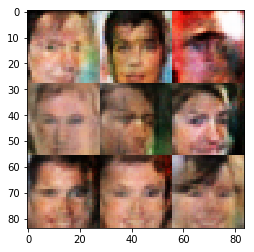

Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 2.8278
Epoch 1/1... Discriminator Loss: 0.6519... Generator Loss: 1.9354
Epoch 1/1... Discriminator Loss: 0.3342... Generator Loss: 1.6115
Epoch 1/1... Discriminator Loss: 0.8644... Generator Loss: 1.3564
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 0.5744... Generator Loss: 1.5835
Epoch 1/1... Discriminator Loss: 1.0159... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 0.1649... Generator Loss: 2.7526
Epoch 1/1... Discriminator Loss: 3.1892... Generator Loss: 0.0507
Epoch 1/1... Discriminator Loss: 0.6066... Generator Loss: 2.9427


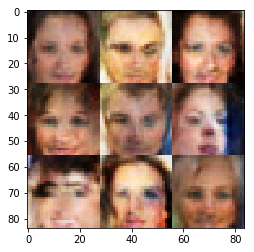

Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 0.5934... Generator Loss: 1.0812
Epoch 1/1... Discriminator Loss: 0.9640... Generator Loss: 1.0553
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 1.6594
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.4766
Epoch 1/1... Discriminator Loss: 0.7955... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 0.5675
Epoch 1/1... Discriminator Loss: 0.2407... Generator Loss: 4.1000
Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 1.1051
Epoch 1/1... Discriminator Loss: 0.8928... Generator Loss: 0.8566


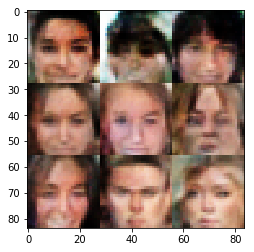

Epoch 1/1... Discriminator Loss: 1.6359... Generator Loss: 0.2800
Epoch 1/1... Discriminator Loss: 1.5497... Generator Loss: 0.3949
Epoch 1/1... Discriminator Loss: 0.9225... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 0.2474... Generator Loss: 2.1120
Epoch 1/1... Discriminator Loss: 0.6791... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 0.2697... Generator Loss: 1.7895
Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 2.7981
Epoch 1/1... Discriminator Loss: 0.5490... Generator Loss: 4.7454
Epoch 1/1... Discriminator Loss: 0.9353... Generator Loss: 1.2160
Epoch 1/1... Discriminator Loss: 0.7695... Generator Loss: 1.1115


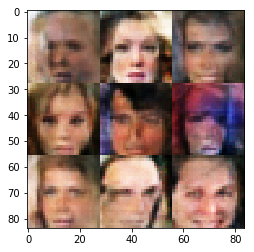

Epoch 1/1... Discriminator Loss: 0.7867... Generator Loss: 1.0195
Epoch 1/1... Discriminator Loss: 0.7785... Generator Loss: 1.7429
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 3.2247
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 0.1898... Generator Loss: 3.2831
Epoch 1/1... Discriminator Loss: 0.4610... Generator Loss: 1.3686
Epoch 1/1... Discriminator Loss: 0.3471... Generator Loss: 1.5183
Epoch 1/1... Discriminator Loss: 1.5081... Generator Loss: 0.3382
Epoch 1/1... Discriminator Loss: 1.5997... Generator Loss: 0.4336
Epoch 1/1... Discriminator Loss: 0.3246... Generator Loss: 3.7601


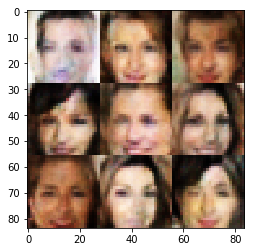

Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.4636
Epoch 1/1... Discriminator Loss: 0.7094... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 0.7557... Generator Loss: 0.9641
Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 2.1308
Epoch 1/1... Discriminator Loss: 2.2392... Generator Loss: 3.2229
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.4017
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 0.5628
Epoch 1/1... Discriminator Loss: 0.7068... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 0.2485... Generator Loss: 2.7272
Epoch 1/1... Discriminator Loss: 0.2576... Generator Loss: 2.4527


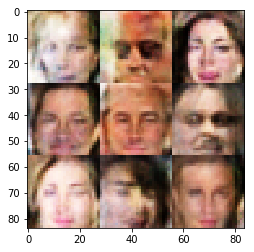

Epoch 1/1... Discriminator Loss: 0.7296... Generator Loss: 5.4475
Epoch 1/1... Discriminator Loss: 0.1213... Generator Loss: 3.7490
Epoch 1/1... Discriminator Loss: 0.1998... Generator Loss: 2.1337
Epoch 1/1... Discriminator Loss: 0.1206... Generator Loss: 4.2610
Epoch 1/1... Discriminator Loss: 0.3557... Generator Loss: 2.8625
Epoch 1/1... Discriminator Loss: 0.7472... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 0.1011... Generator Loss: 3.5430
Epoch 1/1... Discriminator Loss: 2.3153... Generator Loss: 0.1838
Epoch 1/1... Discriminator Loss: 0.2194... Generator Loss: 2.2210
Epoch 1/1... Discriminator Loss: 0.6273... Generator Loss: 1.1257


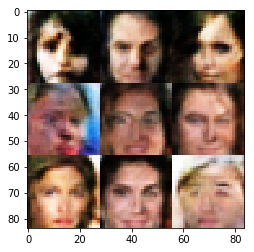

Epoch 1/1... Discriminator Loss: 0.6399... Generator Loss: 1.0489
Epoch 1/1... Discriminator Loss: 0.6785... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 0.6689... Generator Loss: 1.0938
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 1.1749
Epoch 1/1... Discriminator Loss: 0.2332... Generator Loss: 2.2878
Epoch 1/1... Discriminator Loss: 0.8216... Generator Loss: 1.0644
Epoch 1/1... Discriminator Loss: 1.0380... Generator Loss: 0.8971
Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 0.5836
Epoch 1/1... Discriminator Loss: 0.5452... Generator Loss: 1.0811
Epoch 1/1... Discriminator Loss: 0.6041... Generator Loss: 1.0123


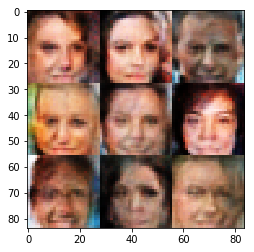

Epoch 1/1... Discriminator Loss: 0.7926... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.4921... Generator Loss: 0.3048
Epoch 1/1... Discriminator Loss: 0.7246... Generator Loss: 1.1786
Epoch 1/1... Discriminator Loss: 0.6439... Generator Loss: 1.1594
Epoch 1/1... Discriminator Loss: 0.5281... Generator Loss: 1.5352
Epoch 1/1... Discriminator Loss: 0.8347... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.4780
Epoch 1/1... Discriminator Loss: 0.3382... Generator Loss: 2.6912
Epoch 1/1... Discriminator Loss: 2.4930... Generator Loss: 2.2341
Epoch 1/1... Discriminator Loss: 3.4871... Generator Loss: 0.0573


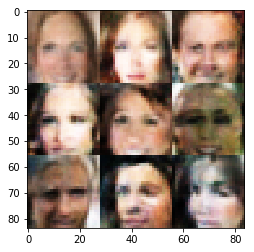

Epoch 1/1... Discriminator Loss: 0.9615... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 1.7916... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 0.1579... Generator Loss: 3.2977
Epoch 1/1... Discriminator Loss: 0.5023... Generator Loss: 1.1442
Epoch 1/1... Discriminator Loss: 0.5385... Generator Loss: 1.1354
Epoch 1/1... Discriminator Loss: 0.8811... Generator Loss: 2.8721
Epoch 1/1... Discriminator Loss: 0.9556... Generator Loss: 3.6202
Epoch 1/1... Discriminator Loss: 0.5106... Generator Loss: 1.2062
Epoch 1/1... Discriminator Loss: 0.1195... Generator Loss: 3.7728
Epoch 1/1... Discriminator Loss: 0.1998... Generator Loss: 2.0576


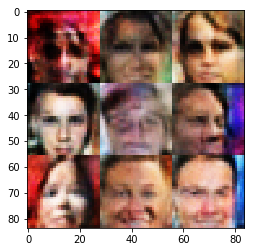

Epoch 1/1... Discriminator Loss: 0.1796... Generator Loss: 2.2662
Epoch 1/1... Discriminator Loss: 0.4386... Generator Loss: 2.0526
Epoch 1/1... Discriminator Loss: 0.1547... Generator Loss: 2.3624
Epoch 1/1... Discriminator Loss: 0.1475... Generator Loss: 2.3168
Epoch 1/1... Discriminator Loss: 0.5183... Generator Loss: 1.1729
Epoch 1/1... Discriminator Loss: 0.2904... Generator Loss: 1.8358
Epoch 1/1... Discriminator Loss: 0.3876... Generator Loss: 1.4350
Epoch 1/1... Discriminator Loss: 1.5246... Generator Loss: 2.2393
Epoch 1/1... Discriminator Loss: 0.6753... Generator Loss: 1.8926
Epoch 1/1... Discriminator Loss: 0.1338... Generator Loss: 3.2547


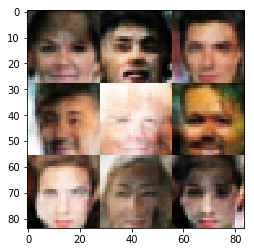

Epoch 1/1... Discriminator Loss: 0.4636... Generator Loss: 1.4964
Epoch 1/1... Discriminator Loss: 0.1226... Generator Loss: 3.2868
Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 1.0784
Epoch 1/1... Discriminator Loss: 0.9081... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 0.2454... Generator Loss: 2.6263
Epoch 1/1... Discriminator Loss: 0.7133... Generator Loss: 1.4944
Epoch 1/1... Discriminator Loss: 0.4056... Generator Loss: 1.5315
Epoch 1/1... Discriminator Loss: 0.5288... Generator Loss: 1.1208
Epoch 1/1... Discriminator Loss: 0.9940... Generator Loss: 1.0671
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 0.5337


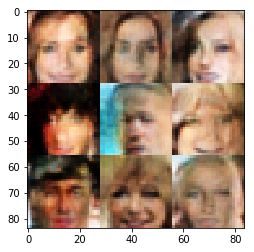

Epoch 1/1... Discriminator Loss: 0.7710... Generator Loss: 1.6477
Epoch 1/1... Discriminator Loss: 0.9203... Generator Loss: 0.9137
Epoch 1/1... Discriminator Loss: 0.9506... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.3734
Epoch 1/1... Discriminator Loss: 1.0467... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 0.4942
Epoch 1/1... Discriminator Loss: 0.6973... Generator Loss: 1.1354
Epoch 1/1... Discriminator Loss: 0.8757... Generator Loss: 0.9143
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 0.4851


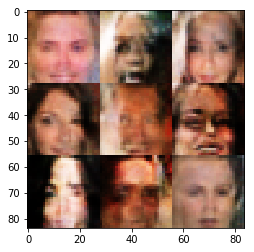

Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 0.9563... Generator Loss: 1.1610
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.4854
Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.4673
Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 1.1429
Epoch 1/1... Discriminator Loss: 0.7897... Generator Loss: 1.0254
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 0.5324
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.3899
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 0.6110


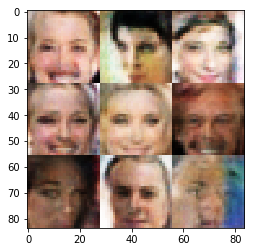

Epoch 1/1... Discriminator Loss: 0.9312... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 0.5371... Generator Loss: 1.4243
Epoch 1/1... Discriminator Loss: 2.6339... Generator Loss: 0.1032
Epoch 1/1... Discriminator Loss: 0.8747... Generator Loss: 1.0387
Epoch 1/1... Discriminator Loss: 3.0371... Generator Loss: 2.9603
Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 1.0394
Epoch 1/1... Discriminator Loss: 0.8887... Generator Loss: 0.9101
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 0.5525
Epoch 1/1... Discriminator Loss: 0.7875... Generator Loss: 1.7125
Epoch 1/1... Discriminator Loss: 0.9576... Generator Loss: 0.6166


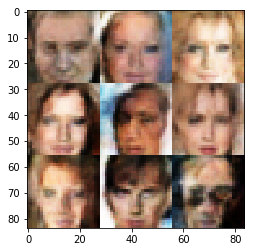

Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.4162
Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.3913
Epoch 1/1... Discriminator Loss: 0.7766... Generator Loss: 1.0751
Epoch 1/1... Discriminator Loss: 0.9081... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 0.5118
Epoch 1/1... Discriminator Loss: 0.8108... Generator Loss: 2.2803
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.2982
Epoch 1/1... Discriminator Loss: 0.6412... Generator Loss: 1.0491
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.4648


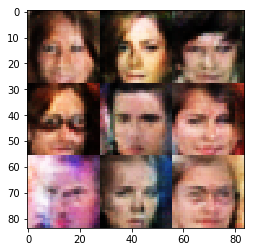

Epoch 1/1... Discriminator Loss: 0.8942... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 0.7854... Generator Loss: 1.5763
Epoch 1/1... Discriminator Loss: 0.7109... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 1.5364... Generator Loss: 0.3407
Epoch 1/1... Discriminator Loss: 1.8128... Generator Loss: 0.2724
Epoch 1/1... Discriminator Loss: 0.2749... Generator Loss: 1.7237
Epoch 1/1... Discriminator Loss: 0.7371... Generator Loss: 0.9077
Epoch 1/1... Discriminator Loss: 0.4284... Generator Loss: 1.4683
Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 0.8649... Generator Loss: 0.9318


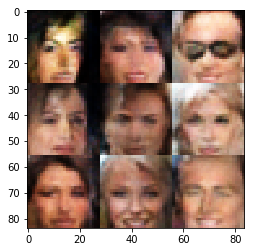

Epoch 1/1... Discriminator Loss: 1.0128... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 0.7891... Generator Loss: 1.1049
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.6423
Epoch 1/1... Discriminator Loss: 0.8881... Generator Loss: 1.3674
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 0.5820
Epoch 1/1... Discriminator Loss: 0.8448... Generator Loss: 1.0025
Epoch 1/1... Discriminator Loss: 0.7633... Generator Loss: 0.9541
Epoch 1/1... Discriminator Loss: 1.5381... Generator Loss: 0.3001
Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 0.6453


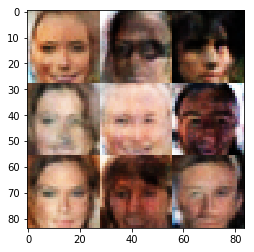

Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 0.4507
Epoch 1/1... Discriminator Loss: 0.9983... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.4800
Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 1.6767
Epoch 1/1... Discriminator Loss: 0.5435... Generator Loss: 1.7286
Epoch 1/1... Discriminator Loss: 0.6404... Generator Loss: 1.0713
Epoch 1/1... Discriminator Loss: 0.7907... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 0.6594... Generator Loss: 0.9814
Epoch 1/1... Discriminator Loss: 0.4606... Generator Loss: 1.5006


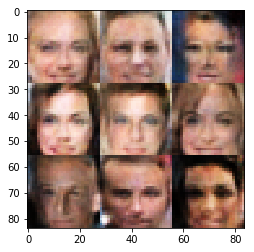

Epoch 1/1... Discriminator Loss: 0.7883... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.0282... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 0.5857
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 0.4953
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.4474
Epoch 1/1... Discriminator Loss: 1.1249... Generator Loss: 0.5431
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 0.7916... Generator Loss: 1.1009
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.3601
Epoch 1/1... Discriminator Loss: 1.1058... Generator Loss: 0.7060


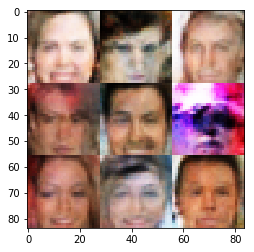

Epoch 1/1... Discriminator Loss: 0.8678... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 1.8599
Epoch 1/1... Discriminator Loss: 0.4102... Generator Loss: 1.3855
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.3412
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 0.9576... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 0.9457... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 0.4168
Epoch 1/1... Discriminator Loss: 0.9718... Generator Loss: 0.5960
Epoch 1/1... Discriminator Loss: 0.8177... Generator Loss: 0.8581


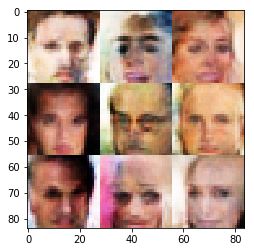

Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.3734
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.5616
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 0.3324... Generator Loss: 1.8615
Epoch 1/1... Discriminator Loss: 0.5060... Generator Loss: 3.2256
Epoch 1/1... Discriminator Loss: 2.7373... Generator Loss: 3.2375
Epoch 1/1... Discriminator Loss: 0.5511... Generator Loss: 1.1595
Epoch 1/1... Discriminator Loss: 0.1671... Generator Loss: 2.4960
Epoch 1/1... Discriminator Loss: 0.1791... Generator Loss: 2.9863
Epoch 1/1... Discriminator Loss: 1.9519... Generator Loss: 0.2181


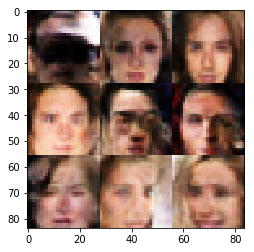

Epoch 1/1... Discriminator Loss: 0.9451... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 0.5008
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.4001
Epoch 1/1... Discriminator Loss: 0.1293... Generator Loss: 3.4896
Epoch 1/1... Discriminator Loss: 0.4743... Generator Loss: 1.2430
Epoch 1/1... Discriminator Loss: 3.2062... Generator Loss: 2.5120
Epoch 1/1... Discriminator Loss: 0.8377... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 0.4951
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 0.5727
Epoch 1/1... Discriminator Loss: 1.0101... Generator Loss: 0.6629


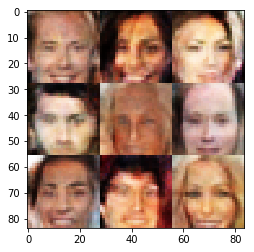

Epoch 1/1... Discriminator Loss: 1.2077... Generator Loss: 0.5102
Epoch 1/1... Discriminator Loss: 0.9824... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 0.5002
Epoch 1/1... Discriminator Loss: 0.6451... Generator Loss: 1.5677
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 0.5037
Epoch 1/1... Discriminator Loss: 0.4245... Generator Loss: 1.3015
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 0.8827
Epoch 1/1... Discriminator Loss: 0.8252... Generator Loss: 1.6883


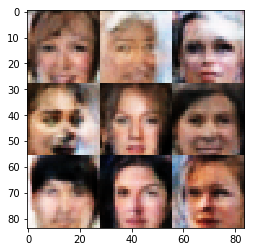

Epoch 1/1... Discriminator Loss: 0.5789... Generator Loss: 2.5772
Epoch 1/1... Discriminator Loss: 0.1231... Generator Loss: 2.5525
Epoch 1/1... Discriminator Loss: 0.6767... Generator Loss: 1.1233
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 0.5043... Generator Loss: 1.1219
Epoch 1/1... Discriminator Loss: 0.1919... Generator Loss: 2.5446
Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 0.6330
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.4289
Epoch 1/1... Discriminator Loss: 0.3182... Generator Loss: 3.6021
Epoch 1/1... Discriminator Loss: 0.2138... Generator Loss: 3.3838


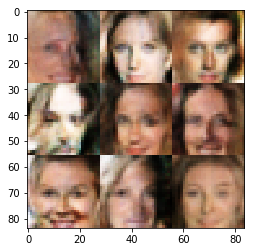

Epoch 1/1... Discriminator Loss: 2.7609... Generator Loss: 0.1469
Epoch 1/1... Discriminator Loss: 0.4039... Generator Loss: 1.4020
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 0.2875... Generator Loss: 3.3581
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 0.6186... Generator Loss: 1.1066
Epoch 1/1... Discriminator Loss: 0.6528... Generator Loss: 1.1640
Epoch 1/1... Discriminator Loss: 0.7920... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 0.8391... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 0.8226... Generator Loss: 0.8418


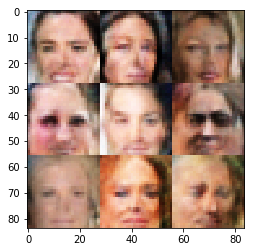

Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 0.6153
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.3541
Epoch 1/1... Discriminator Loss: 0.8460... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 0.7225... Generator Loss: 3.4038
Epoch 1/1... Discriminator Loss: 0.8901... Generator Loss: 1.0674
Epoch 1/1... Discriminator Loss: 1.5522... Generator Loss: 0.2632
Epoch 1/1... Discriminator Loss: 0.8958... Generator Loss: 0.8758
Epoch 1/1... Discriminator Loss: 0.7543... Generator Loss: 0.8855
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.3625
Epoch 1/1... Discriminator Loss: 2.4285... Generator Loss: 0.1161


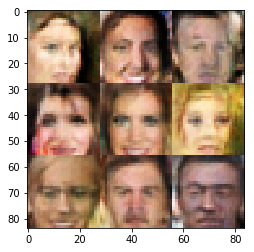

Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 1.0665
Epoch 1/1... Discriminator Loss: 0.7178... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 0.4202... Generator Loss: 1.4115
Epoch 1/1... Discriminator Loss: 0.3422... Generator Loss: 2.2354
Epoch 1/1... Discriminator Loss: 2.1074... Generator Loss: 0.2294
Epoch 1/1... Discriminator Loss: 0.3707... Generator Loss: 2.5021
Epoch 1/1... Discriminator Loss: 0.2860... Generator Loss: 1.8617
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 3.3939
Epoch 1/1... Discriminator Loss: 0.6631... Generator Loss: 1.0177
Epoch 1/1... Discriminator Loss: 0.3542... Generator Loss: 3.3547


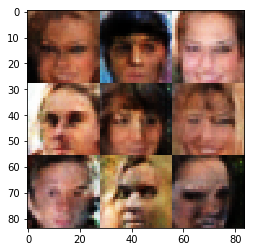

Epoch 1/1... Discriminator Loss: 0.6166... Generator Loss: 1.1419
Epoch 1/1... Discriminator Loss: 0.7963... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.3929
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.3766
Epoch 1/1... Discriminator Loss: 0.5929... Generator Loss: 1.5974
Epoch 1/1... Discriminator Loss: 1.6566... Generator Loss: 3.2220
Epoch 1/1... Discriminator Loss: 0.2817... Generator Loss: 1.8382
Epoch 1/1... Discriminator Loss: 0.3024... Generator Loss: 2.6016
Epoch 1/1... Discriminator Loss: 0.8574... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 0.1754... Generator Loss: 3.7526


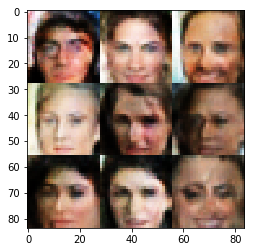

Epoch 1/1... Discriminator Loss: 0.7922... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.8011... Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 0.1255... Generator Loss: 3.5759
Epoch 1/1... Discriminator Loss: 0.1369... Generator Loss: 2.7291
Epoch 1/1... Discriminator Loss: 1.8639... Generator Loss: 0.2034
Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 0.6430
Epoch 1/1... Discriminator Loss: 0.9229... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 0.9165... Generator Loss: 2.2012
Epoch 1/1... Discriminator Loss: 0.7670... Generator Loss: 1.0287
Epoch 1/1... Discriminator Loss: 0.7341... Generator Loss: 1.4449


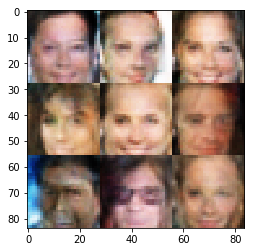

Epoch 1/1... Discriminator Loss: 1.5261... Generator Loss: 0.3008
Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 0.5925
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 3.5675
Epoch 1/1... Discriminator Loss: 0.7664... Generator Loss: 1.5864
Epoch 1/1... Discriminator Loss: 0.6085... Generator Loss: 1.0988
Epoch 1/1... Discriminator Loss: 0.3572... Generator Loss: 1.8644
Epoch 1/1... Discriminator Loss: 0.8586... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 0.5806... Generator Loss: 1.1872
Epoch 1/1... Discriminator Loss: 0.9994... Generator Loss: 0.8072


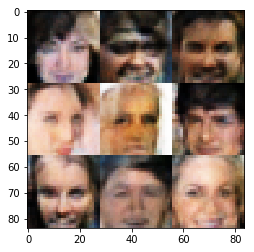

Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 0.5091
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 0.7594... Generator Loss: 1.0762
Epoch 1/1... Discriminator Loss: 0.9219... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 0.9075... Generator Loss: 0.9096
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.5594
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.4174
Epoch 1/1... Discriminator Loss: 0.9464... Generator Loss: 1.1312
Epoch 1/1... Discriminator Loss: 0.8636... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 0.8645... Generator Loss: 1.0568


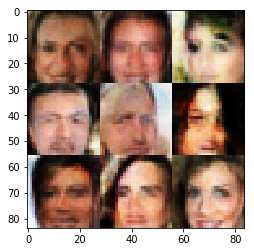

Epoch 1/1... Discriminator Loss: 0.8027... Generator Loss: 1.0553
Epoch 1/1... Discriminator Loss: 0.5214... Generator Loss: 1.4867
Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.8019... Generator Loss: 0.2322
Epoch 1/1... Discriminator Loss: 0.5180... Generator Loss: 2.0212
Epoch 1/1... Discriminator Loss: 0.5132... Generator Loss: 1.1276
Epoch 1/1... Discriminator Loss: 0.8651... Generator Loss: 1.6526
Epoch 1/1... Discriminator Loss: 0.4457... Generator Loss: 1.4783
Epoch 1/1... Discriminator Loss: 0.7006... Generator Loss: 1.0823
Epoch 1/1... Discriminator Loss: 0.8311... Generator Loss: 1.0974


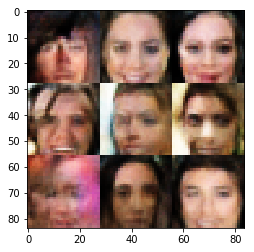

Epoch 1/1... Discriminator Loss: 0.8333... Generator Loss: 2.5450
Epoch 1/1... Discriminator Loss: 0.4117... Generator Loss: 1.3375
Epoch 1/1... Discriminator Loss: 0.9860... Generator Loss: 0.5929
Epoch 1/1... Discriminator Loss: 1.5800... Generator Loss: 0.2924
Epoch 1/1... Discriminator Loss: 0.5990... Generator Loss: 0.9784
Epoch 1/1... Discriminator Loss: 0.8322... Generator Loss: 1.6845
Epoch 1/1... Discriminator Loss: 0.1586... Generator Loss: 2.7894
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 2.8829
Epoch 1/1... Discriminator Loss: 0.2375... Generator Loss: 3.8791
Epoch 1/1... Discriminator Loss: 0.8707... Generator Loss: 0.6507


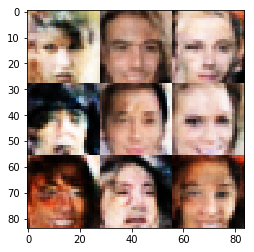

Epoch 1/1... Discriminator Loss: 2.0471... Generator Loss: 0.1813
Epoch 1/1... Discriminator Loss: 0.3628... Generator Loss: 1.6997
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.3344
Epoch 1/1... Discriminator Loss: 0.6736... Generator Loss: 1.1150
Epoch 1/1... Discriminator Loss: 0.8447... Generator Loss: 1.0677
Epoch 1/1... Discriminator Loss: 0.9304... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 0.9377... Generator Loss: 1.0453
Epoch 1/1... Discriminator Loss: 0.9230... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 0.5481
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.3920


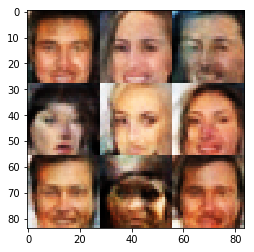

Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.4962
Epoch 1/1... Discriminator Loss: 0.8471... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 1.7582
Epoch 1/1... Discriminator Loss: 0.7180... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 0.7855... Generator Loss: 0.9275
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 0.8358... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 0.9624... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 0.7520... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 0.4067... Generator Loss: 1.3647


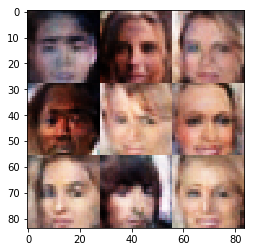

Epoch 1/1... Discriminator Loss: 0.7308... Generator Loss: 0.8668
Epoch 1/1... Discriminator Loss: 0.8472... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 0.9445... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.3517
Epoch 1/1... Discriminator Loss: 0.5162... Generator Loss: 1.8234
Epoch 1/1... Discriminator Loss: 0.8315... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.5168
Epoch 1/1... Discriminator Loss: 0.4548... Generator Loss: 1.3281
Epoch 1/1... Discriminator Loss: 0.1625... Generator Loss: 3.5058
Epoch 1/1... Discriminator Loss: 1.7950... Generator Loss: 2.0593


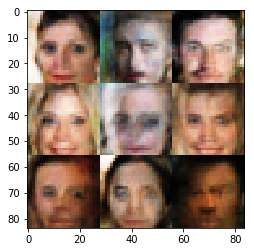

Epoch 1/1... Discriminator Loss: 0.3688... Generator Loss: 3.3639
Epoch 1/1... Discriminator Loss: 0.7831... Generator Loss: 1.6003
Epoch 1/1... Discriminator Loss: 0.6361... Generator Loss: 1.1139
Epoch 1/1... Discriminator Loss: 0.7885... Generator Loss: 1.1364
Epoch 1/1... Discriminator Loss: 0.7661... Generator Loss: 1.3135
Epoch 1/1... Discriminator Loss: 0.9374... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 0.9290
Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 1.1803
Epoch 1/1... Discriminator Loss: 0.9524... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 0.4403


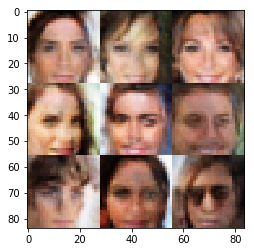

Epoch 1/1... Discriminator Loss: 0.7927... Generator Loss: 1.2756
Epoch 1/1... Discriminator Loss: 0.6759... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 0.9916... Generator Loss: 1.3800
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.3705
Epoch 1/1... Discriminator Loss: 1.7625... Generator Loss: 0.2937
Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 1.1420
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 1.4849
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 0.5389
Epoch 1/1... Discriminator Loss: 0.8277... Generator Loss: 1.7506
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 0.8894


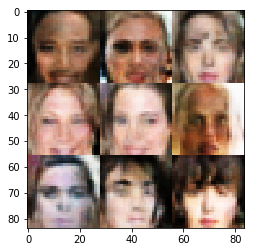

Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 2.3319
Epoch 1/1... Discriminator Loss: 0.4253... Generator Loss: 1.6007
Epoch 1/1... Discriminator Loss: 0.2218... Generator Loss: 2.9546
Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 1.3697
Epoch 1/1... Discriminator Loss: 0.8344... Generator Loss: 1.3551
Epoch 1/1... Discriminator Loss: 0.4253... Generator Loss: 1.6560
Epoch 1/1... Discriminator Loss: 1.0538... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 0.6357... Generator Loss: 1.1142
Epoch 1/1... Discriminator Loss: 0.9791... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 0.6085... Generator Loss: 1.0699


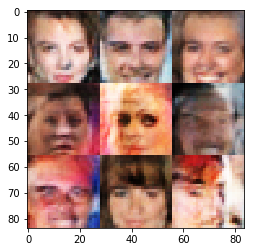

Epoch 1/1... Discriminator Loss: 2.3351... Generator Loss: 0.1311
Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 0.5799... Generator Loss: 1.2763
Epoch 1/1... Discriminator Loss: 0.2801... Generator Loss: 1.8285
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.5821
Epoch 1/1... Discriminator Loss: 1.8123... Generator Loss: 3.2732
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 2.4139
Epoch 1/1... Discriminator Loss: 0.5760... Generator Loss: 1.0113
Epoch 1/1... Discriminator Loss: 0.2420... Generator Loss: 2.3886
Epoch 1/1... Discriminator Loss: 2.6324... Generator Loss: 0.0959


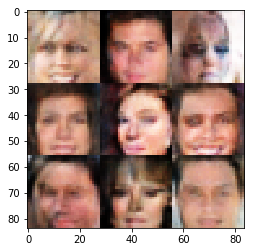

Epoch 1/1... Discriminator Loss: 0.6883... Generator Loss: 1.1432
Epoch 1/1... Discriminator Loss: 0.6439... Generator Loss: 1.0099
Epoch 1/1... Discriminator Loss: 0.9093... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 0.4847
Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 0.4787
Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 0.7762... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 0.7628... Generator Loss: 1.0296
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 0.5605


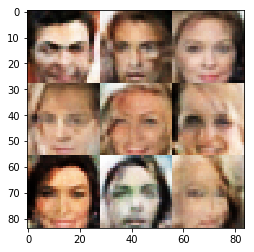

Epoch 1/1... Discriminator Loss: 0.9995... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 1.0236... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 0.9140... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 0.9169... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 0.6153
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 0.5173
Epoch 1/1... Discriminator Loss: 0.1489... Generator Loss: 2.9508
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.3961
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 0.5037


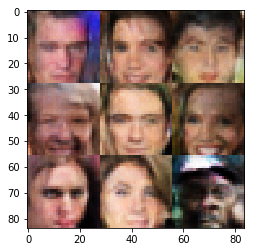

Epoch 1/1... Discriminator Loss: 0.3812... Generator Loss: 1.5104
Epoch 1/1... Discriminator Loss: 0.6834... Generator Loss: 2.1241
Epoch 1/1... Discriminator Loss: 0.4674... Generator Loss: 4.0435
Epoch 1/1... Discriminator Loss: 0.2715... Generator Loss: 4.0640
Epoch 1/1... Discriminator Loss: 0.5564... Generator Loss: 1.0980
Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 0.5940
Epoch 1/1... Discriminator Loss: 0.9129... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 1.8013... Generator Loss: 0.2301
Epoch 1/1... Discriminator Loss: 0.2468... Generator Loss: 3.6549
Epoch 1/1... Discriminator Loss: 0.5986... Generator Loss: 0.9737


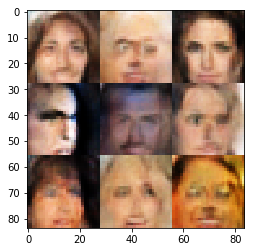

Epoch 1/1... Discriminator Loss: 0.6405... Generator Loss: 1.0332
Epoch 1/1... Discriminator Loss: 0.5895... Generator Loss: 2.3491
Epoch 1/1... Discriminator Loss: 1.6671... Generator Loss: 0.2702
Epoch 1/1... Discriminator Loss: 0.1850... Generator Loss: 2.2661
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.3513
Epoch 1/1... Discriminator Loss: 0.8210... Generator Loss: 0.8929
Epoch 1/1... Discriminator Loss: 0.8811... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 0.6822... Generator Loss: 1.3446
Epoch 1/1... Discriminator Loss: 0.9344... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 0.8355... Generator Loss: 0.8901


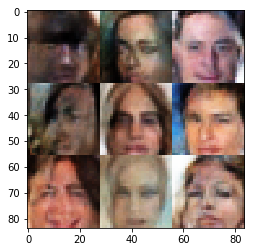

Epoch 1/1... Discriminator Loss: 1.0418... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 0.8312... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.9831... Generator Loss: 0.1708
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 0.5736
Epoch 1/1... Discriminator Loss: 0.7353... Generator Loss: 1.0306
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.3965
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 0.8795... Generator Loss: 1.2832
Epoch 1/1... Discriminator Loss: 0.9950... Generator Loss: 0.7715


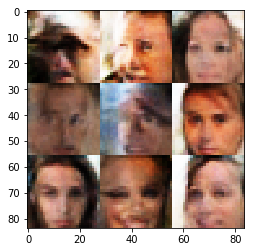

Epoch 1/1... Discriminator Loss: 1.8361... Generator Loss: 0.2062
Epoch 1/1... Discriminator Loss: 0.3876... Generator Loss: 1.6018
Epoch 1/1... Discriminator Loss: 0.3923... Generator Loss: 1.5789
Epoch 1/1... Discriminator Loss: 0.3093... Generator Loss: 1.8094
Epoch 1/1... Discriminator Loss: 0.8252... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 0.8029... Generator Loss: 1.2249
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 0.8329... Generator Loss: 1.0726
Epoch 1/1... Discriminator Loss: 0.7818... Generator Loss: 0.8368


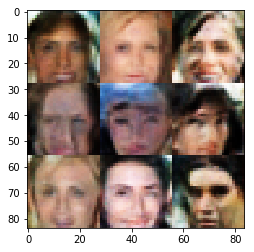

Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 1.1427
Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 0.5046
Epoch 1/1... Discriminator Loss: 0.8199... Generator Loss: 1.4108
Epoch 1/1... Discriminator Loss: 1.0220... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 0.5837... Generator Loss: 0.9817
Epoch 1/1... Discriminator Loss: 0.2287... Generator Loss: 4.3407
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.4117
Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 0.4854... Generator Loss: 3.4546
Epoch 1/1... Discriminator Loss: 0.8502... Generator Loss: 2.2116


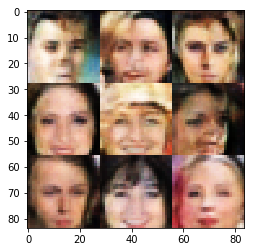

Epoch 1/1... Discriminator Loss: 0.7960... Generator Loss: 0.9620
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.3699
Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 0.4499
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.4707
Epoch 1/1... Discriminator Loss: 0.9087... Generator Loss: 0.9487
Epoch 1/1... Discriminator Loss: 0.8529... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 0.4143
Epoch 1/1... Discriminator Loss: 0.7128... Generator Loss: 1.0271
Epoch 1/1... Discriminator Loss: 1.0018... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.3364


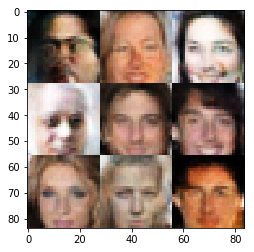

Epoch 1/1... Discriminator Loss: 0.9344... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.4802
Epoch 1/1... Discriminator Loss: 0.9573... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 0.7181... Generator Loss: 1.3660
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 1.0861
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.4927
Epoch 1/1... Discriminator Loss: 0.7919... Generator Loss: 0.9756
Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 0.5035
Epoch 1/1... Discriminator Loss: 0.4081... Generator Loss: 4.0009
Epoch 1/1... Discriminator Loss: 0.3014... Generator Loss: 2.4666


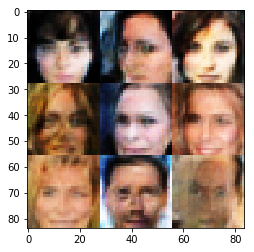

Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 0.5288
Epoch 1/1... Discriminator Loss: 0.5261... Generator Loss: 3.4154
Epoch 1/1... Discriminator Loss: 1.0067... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 1.8445... Generator Loss: 0.2188
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 0.5313
Epoch 1/1... Discriminator Loss: 0.8542... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 0.9346... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 0.9824... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.3977
Epoch 1/1... Discriminator Loss: 1.0191... Generator Loss: 0.6195


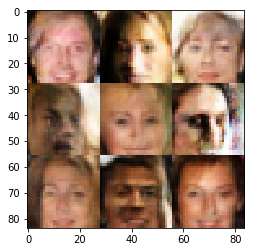

Epoch 1/1... Discriminator Loss: 0.8295... Generator Loss: 1.1627
Epoch 1/1... Discriminator Loss: 0.6997... Generator Loss: 0.9432
Epoch 1/1... Discriminator Loss: 0.7706... Generator Loss: 1.0475
Epoch 1/1... Discriminator Loss: 0.7220... Generator Loss: 1.1592
Epoch 1/1... Discriminator Loss: 0.9016... Generator Loss: 1.1324
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.4313
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 0.5265
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 0.4830
Epoch 1/1... Discriminator Loss: 0.9960... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.0059... Generator Loss: 0.6774


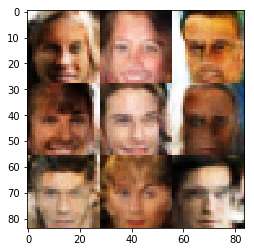

Epoch 1/1... Discriminator Loss: 0.9429... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.9416
Epoch 1/1... Discriminator Loss: 0.4601... Generator Loss: 1.3314
Epoch 1/1... Discriminator Loss: 0.4558... Generator Loss: 1.3400
Epoch 1/1... Discriminator Loss: 0.8259... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 0.8159... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.6778... Generator Loss: 0.2916
Epoch 1/1... Discriminator Loss: 0.6706... Generator Loss: 3.2046
Epoch 1/1... Discriminator Loss: 2.2377... Generator Loss: 2.0918
Epoch 1/1... Discriminator Loss: 0.7373... Generator Loss: 0.9691


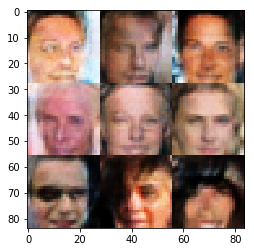

Epoch 1/1... Discriminator Loss: 0.9500... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.4900
Epoch 1/1... Discriminator Loss: 0.4127... Generator Loss: 1.6116
Epoch 1/1... Discriminator Loss: 0.4634... Generator Loss: 1.1897
Epoch 1/1... Discriminator Loss: 0.1262... Generator Loss: 3.1274
Epoch 1/1... Discriminator Loss: 0.6144... Generator Loss: 1.4080


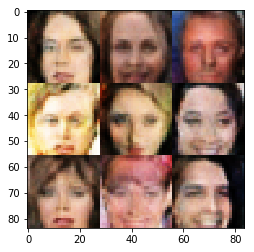

In [13]:
batch_size = 16 # Going  >= 32 causes out of memory.
z_dim = 128
learning_rate = 0.0009
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.